# Football Match Prediction Model v1

This notebook develops the first machine learning model for football match outcome prediction using the master dataset.

## Objectives:
- Load the master dataset with comprehensive match features
- Perform exploratory data analysis and feature engineering
- Build and evaluate prediction models
- Compare different algorithms and approaches
- Generate predictions and model insights

## Dataset Features:
- Match statistics (possession, shots, passes, etc.)
- Team wage information and squad details
- Historical form metrics (rolling 5-match averages)
- Rest days and contextual match information
- Both team and opponent perspectives

In [38]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import pearsonr,ranksums

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [39]:
# Set up paths
project_root = Path().resolve().parent.parent.parent
data_masters = project_root / 'data' / 'prod' / 'processed' / 'masters'
models_dir = project_root / 'models' / 'premier_league'

# Create models directory if it doesn't exist
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Masters data: {data_masters}")
print(f"Models directory: {models_dir}")

Project root: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football
Masters data: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\data\prod\processed\masters
Models directory: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league


## Data Loading

Load the master dataset created in the data engineering phase.

In [40]:
# Load master dataset (prefer parquet for efficiency)
dataset_file = data_masters / 'match_stats_master_complete_v1.parquet'

if dataset_file.exists():
    df = pd.read_parquet(dataset_file)
    print(f"✓ Dataset loaded successfully")
    print(f"  Shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
else:
    print("✗ Master dataset not found. Please run master_creation_v1.ipynb first.")
    df = None

✓ Dataset loaded successfully
  Shape: (5711, 258)
  Memory usage: 15.7 MB


## Feature Dropping

In [41]:
id_cols = [
    'date',
    'comp',
    'round',
    'season',
    'team_id',
    'full_match_report_url',
    'team_name',
    'opponent',
    'opponent_id',
    
]

match_cols = [
    'referee',
    'start_time',
    'dayofweek'
]

target_cols = [
    'result',
]

stats_team_A = [
    'venue',
    'Aerials Won_favor_form_avg',
    'Aerials Won_favor_form_sum',
    'Clearances_favor_form_avg',
    'Clearances_favor_form_sum',
    'Corners_favor_form_avg',
    'Corners_favor_form_sum',
    'Crosses_favor_form_avg',
    'Crosses_favor_form_sum',
    'Fouls_favor_form_avg',
    'Fouls_favor_form_sum',
    'Goal Kicks_favor_form_avg',
    'Goal Kicks_favor_form_sum',
    'Interceptions_favor_form_avg',
    'Interceptions_favor_form_sum',
    'Long Balls_favor_form_avg',
    'Long Balls_favor_form_sum',
    'Offsides_favor_form_avg',
    'Offsides_favor_form_sum',
    'Passing Accuracy_favor_form_avg',
    'Passing Accuracy_favor_form_sum',
    'Possession_favor_form_avg',
    'Possession_favor_form_sum',
    'Saves_favor_form_avg',
    'Saves_favor_form_sum',
    'Shots on Target_favor_form_avg',
    'Shots on Target_favor_form_sum',
    'Tackles_favor_form_avg',
    'Tackles_favor_form_sum',
    'Throw Ins_favor_form_avg',
    'Throw Ins_favor_form_sum',
    'Touches_favor_form_avg',
    'Touches_favor_form_sum',
    'Aerials Won_against_form_avg',
    'Aerials Won_against_form_sum',
    'Clearances_against_form_avg',
    'Clearances_against_form_sum',
    'Corners_against_form_avg',
    'Corners_against_form_sum',
    'Crosses_against_form_avg',
    'Crosses_against_form_sum',
    'Fouls_against_form_avg',
    'Fouls_against_form_sum',
    'Goal Kicks_against_form_avg',
    'Goal Kicks_against_form_sum',
    'Interceptions_against_form_avg',
    'Interceptions_against_form_sum',
    'Long Balls_against_form_avg',
    'Long Balls_against_form_sum',
    'Offsides_against_form_avg',
    'Offsides_against_form_sum',
    'Passing Accuracy_against_form_avg',
    'Passing Accuracy_against_form_sum',
    'Possession_against_form_avg',
    'Possession_against_form_sum',
    'Saves_against_form_avg',
    'Saves_against_form_sum',
    'Shots on Target_against_form_avg',
    'Shots on Target_against_form_sum',
    'Tackles_against_form_avg',
    'Tackles_against_form_sum',
    'Throw Ins_against_form_avg',
    'Throw Ins_against_form_sum',
    'Touches_against_form_avg',
    'Touches_against_form_sum',
    'points_form_avg',
    'points_form_sum',
    'rest_days',
    'rest_days_form_avg',
    'rest_days_form_sum',
    'xg_for_form_avg',
    'xg_for_form_sum',
    'xg_against_form_avg',
    'xg_against_form_sum',
    'goals_for_form_avg',
    'goals_for_form_sum',
    'goals_against_form_avg',
    'goals_against_form_sum'
]

columnas_team_A_validacion = [
    'Aerials Won_favor',
    'Clearances_favor',
    'Corners_favor',
    'Crosses_favor',
    'Fouls_favor',
    'Goal Kicks_favor',
    'Interceptions_favor',
    'Long Balls_favor',
    'Offsides_favor',
    'Passing Accuracy_favor',
    'Possession_favor',
    'Saves_favor',
    'Shots on Target_favor',
    'Tackles_favor',
    'Throw Ins_favor',
    'Touches_favor',
    'Aerials Won_against',
    'Clearances_against',
    'Corners_against',
    'Crosses_against',
    'Fouls_against',
    'Goal Kicks_against',
    'Interceptions_against',
    'Long Balls_against',
    'Offsides_against',
    'Passing Accuracy_against',
    'Possession_against',
    'Saves_against',
    'Shots on Target_against',
    'Tackles_against',
    'Throw Ins_against',
    'Touches_against',
    'points',
    'xg_for',
    'xg_against'
]

players_team_A = [
    'age_mean',
    'squad_size',
    'age_max',
    'age_min',
    'avg_wage_dollars',
    'total_wage_bill_dollars',
    'max_wage_dollars',
    'min_wage_dollars'
 
]

stats_team_B = [
    'Aerials Won_favor_opponent_form_avg',
    'Aerials Won_favor_opponent_form_sum',
    'Clearances_favor_opponent_form_avg',
    'Clearances_favor_opponent_form_sum',
    'Corners_favor_opponent_form_avg',
    'Corners_favor_opponent_form_sum',
    'Crosses_favor_opponent_form_avg',
    'Crosses_favor_opponent_form_sum',
    'Fouls_favor_opponent_form_avg',
    'Fouls_favor_opponent_form_sum',
    'Goal Kicks_favor_opponent_form_avg',
    'Goal Kicks_favor_opponent_form_sum',
    'Interceptions_favor_opponent_form_avg',
    'Interceptions_favor_opponent_form_sum',
    'Long Balls_favor_opponent_form_avg',
    'Long Balls_favor_opponent_form_sum',
    'Offsides_favor_opponent_form_avg',
    'Offsides_favor_opponent_form_sum',
    'Passing Accuracy_favor_opponent_form_avg',
    'Passing Accuracy_favor_opponent_form_sum',
    'Possession_favor_opponent_form_avg',
    'Possession_favor_opponent_form_sum',
    'Saves_favor_opponent_form_avg',
    'Saves_favor_opponent_form_sum',
    'Shots on Target_favor_opponent_form_avg',
    'Shots on Target_favor_opponent_form_sum',
    'Tackles_favor_opponent_form_avg',
    'Tackles_favor_opponent_form_sum',
    'Throw Ins_favor_opponent_form_avg',
    'Throw Ins_favor_opponent_form_sum',
    'Touches_favor_opponent_form_avg',
    'Touches_favor_opponent_form_sum',
    'Aerials Won_against_opponent_form_avg',
    'Aerials Won_against_opponent_form_sum',
    'Clearances_against_opponent_form_avg',
    'Clearances_against_opponent_form_sum',
    'Corners_against_opponent_form_avg',
    'Corners_against_opponent_form_sum',
    'Crosses_against_opponent_form_avg',
    'Crosses_against_opponent_form_sum',
    'Fouls_against_opponent_form_avg',
    'Fouls_against_opponent_form_sum',
    'Goal Kicks_against_opponent_form_avg',
    'Goal Kicks_against_opponent_form_sum',
    'Interceptions_against_opponent_form_avg',
    'Interceptions_against_opponent_form_sum',
    'Long Balls_against_opponent_form_avg',
    'Long Balls_against_opponent_form_sum',
    'Offsides_against_opponent_form_avg',
    'Offsides_against_opponent_form_sum',
    'Passing Accuracy_against_opponent_form_avg',
    'Passing Accuracy_against_opponent_form_sum',
    'Possession_against_opponent_form_avg',
    'Possession_against_opponent_form_sum',
    'Saves_against_opponent_form_avg',
    'Saves_against_opponent_form_sum',
    'Shots on Target_against_opponent_form_avg',
    'Shots on Target_against_opponent_form_sum',
    'Tackles_against_opponent_form_avg',
    'Tackles_against_opponent_form_sum',
    'Throw Ins_against_opponent_form_avg',
    'Throw Ins_against_opponent_form_sum',
    'Touches_against_opponent_form_avg',
    'Touches_against_opponent_form_sum',
    'points_opponent_form_avg',
    'points_opponent_form_sum',
    'rest_days_opponent',
    'rest_days_opponent_form_avg',
    'rest_days_opponent_form_sum',
    'xg_for_opponent_form_avg',
    'xg_for_opponent_form_sum',
    'xg_against_opponent_form_avg',
    'xg_against_opponent_form_sum',
    'goals_for_opponent_form_avg',
    'goals_for_opponent_form_sum',
    'goals_against_opponent_form_avg',
    'goals_against_opponent_form_sum'
]

columnas_team_B_validacion = [
    'Aerials Won_favor_opponent',
    'Clearances_favor_opponent',
    'Corners_favor_opponent',
    'Crosses_favor_opponent',
    'Fouls_favor_opponent',
    'Goal Kicks_favor_opponent',
    'Interceptions_favor_opponent',
    'Long Balls_favor_opponent',
    'Offsides_favor_opponent',
    'Passing Accuracy_favor_opponent',
    'Possession_favor_opponent',
    'Saves_favor_opponent',
    'Shots on Target_favor_opponent',
    'Tackles_favor_opponent',
    'Throw Ins_favor_opponent',
    'Touches_favor_opponent',
    'Aerials Won_against_opponent',
    'Clearances_against_opponent',
    'Corners_against_opponent',
    'Crosses_against_opponent',
    'Fouls_against_opponent',
    'Goal Kicks_against_opponent',
    'Interceptions_against_opponent',
    'Long Balls_against_opponent',
    'Offsides_against_opponent',
    'Passing Accuracy_against_opponent',
    'Possession_against_opponent',
    'Saves_against_opponent',
    'Shots on Target_against_opponent',
    'Tackles_against_opponent',
    'Throw Ins_against_opponent',
    'Touches_against_opponent',
    'points_opponent',
    'xg_for_opponent',
    'xg_against_opponent'
]

players_team_B = [
    'opp_age_mean',
    'opp_squad_size',
    'opp_age_max',
    'opp_age_min',
    'opp_avg_wage_dollars',
    'opp_total_wage_bill_dollars',
    'opp_max_wage_dollars',
    'opp_min_wage_dollars'
]

cols_drop = columnas_team_A_validacion + columnas_team_B_validacion

df.drop(cols_drop,axis=1,inplace=True)

## Feature Engineering & Data Preparation

Analyze the dataset structure and target variable distribution.

In [42]:
cols_add_A = [
 'age_mean',
 'squad_size',
 'age_max',
 'age_min',
 'avg_wage_dollars',
 'total_wage_bill_dollars',
 'max_wage_dollars',
 'min_wage_dollars'
]

cols_add_B = [
'opp_age_mean',
 'opp_squad_size',
 'opp_age_max',
 'opp_age_min',
 'opp_avg_wage_dollars',
 'opp_total_wage_bill_dollars',
 'opp_max_wage_dollars',
 'opp_min_wage_dollars' 
]

for columna in range(len(cols_add_A)):
    df[cols_add_A[columna] + '_diff'] = df[cols_add_A[columna]] - df[cols_add_B[columna]]

if df is not None:
    # Basic dataset info
    print("Dataset Overview:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns):,}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Seasons: {sorted(df['season'].unique())}")
    print(f"  Teams: {len(df['team_id'].unique())} unique teams")
    
    # Target variable distribution
    print("\nTarget Variable (Result) Distribution:")
    result_counts = df['result'].value_counts()
    result_pct = df['result'].value_counts(normalize=True) * 100
    
    for result in ['W', 'D', 'L']:
        if result in result_counts:
            print(f"  {result}: {result_counts[result]:,} ({result_pct[result]:.1f}%)")
    
    # Missing values summary
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing_summary / len(df) * 100).round(1)
    
    print(f"\nColumns with missing values (top 10):")
    for col, missing in missing_summary.head(10).items():
        if missing > 0:
            print(f"  {col}: {missing:,} ({missing_pct[col]}%)")

Dataset Overview:
  Rows: 5,711
  Columns: 196
  Date range: 2019-08-04 00:00:00 to 2025-05-28 00:00:00
  Seasons: ['2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
  Teams: 27 unique teams

Target Variable (Result) Distribution:
  W: 2,406 (42.1%)
  D: 1,257 (22.0%)
  L: 2,048 (35.9%)

Columns with missing values (top 10):
  rest_days_opponent_form_sum: 817 (14.3%)
  rest_days_opponent_form_avg: 817 (14.3%)
  xg_for_opponent_form_sum: 796 (13.9%)
  xg_for_opponent_form_avg: 796 (13.9%)
  xg_against_opponent_form_avg: 796 (13.9%)
  xg_against_opponent_form_sum: 796 (13.9%)
  Possession_favor_opponent_form_sum: 794 (13.9%)
  Long Balls_favor_opponent_form_sum: 794 (13.9%)
  Offsides_favor_opponent_form_avg: 794 (13.9%)
  Offsides_favor_opponent_form_sum: 794 (13.9%)


In [43]:
df['dayofweek'] = df['dayofweek'].map({
      'Mon': 'midweek',    
      'Tue': 'midweek',    
      'Wed': 'midweek',    
      'Thu': 'midweek',    
      'Fri': 'Fri',    
      'Sat': 'Sat',    
      'Sun': 'Sun'
})

dummies = pd.get_dummies(
    df['dayofweek'],
    drop_first=False,
    dtype=int
)

df.drop('dayofweek', axis=1, inplace=True)

df = pd.concat([df, dummies], axis=1)

df['venue'] = df['venue'].map({
    'Away': 0,
    'Home': 1,
    'Neutral': 0
})

df['result'] = df['result'].astype('category')

In [44]:
informacion_competencias = pd.get_dummies(
    df['comp'],
    dtype=int
 )

df = pd.concat([df, informacion_competencias], axis=1)

#CREATING NEW TARGET
df['goal_diff'] = df['goals_for'] - df['goals_against']

In [45]:
# Goal-specific features:
df['xg_diff'] = df['xg_for_form_avg'] - df['xg_against_form_avg']
df['shots_ratio'] = df['Shots on Target_favor_form_avg'] / (df['Shots on Target_against_form_avg'] + 1)
df['possession_dominance'] = df['Possession_favor_form_avg'] - 50  # Home field effect
df['attacking_pressure'] = df['Corners_favor_form_avg'] + df['Crosses_favor_form_avg']

# Defensive solidity
df['defensive_actions'] = df['Tackles_favor_form_avg'] + df['Interceptions_favor_form_avg'] + df['Clearances_favor_form_avg']

## Feature Selection

### Features a evaluar

In [46]:
id_cols = [
    'date',
    'comp',
    'round',
    'season',
    'team_id',
    'full_match_report_url',
    'team_name',
    'opponent',
    'opponent_id',
    'referee',
    'start_time'
]

features = [
    'Passing Accuracy_against_opponent_form_avg',
    'goals_for_opponent_form_avg',
    'Throw Ins_favor_opponent_form_sum',
    'Passing Accuracy_favor_opponent_form_sum',
    'Saves_against_form_sum',
    'Touches_favor_form_sum',
    'Clearances_against_form_sum',
    'Shots on Target_against_form_sum',
    'Touches_favor_opponent_form_avg',
    'Interceptions_against_opponent_form_avg',
    'rest_days_opponent',
    'xg_against_opponent_form_avg',
    'Aerials Won_favor_opponent_form_sum',
    'goals_against_opponent_form_sum',
    'points_opponent_form_avg',
    'rest_days_form_avg',
    'Community Shield',
    'Corners_favor_form_sum',
    'min_wage_dollars',
    'Sun',
    'Possession_favor_opponent_form_avg',
    'Clearances_against_opponent_form_avg',
    'xg_for_opponent_form_sum',
    'Tackles_against_form_avg',
    'Throw Ins_against_opponent_form_sum',
    'Passing Accuracy_against_form_avg',
    'Goal Kicks_against_form_sum',
    'Fouls_against_opponent_form_avg',
    'Touches_against_form_avg',
    'Tackles_favor_form_avg',
    'Tackles_against_opponent_form_avg',
    'rest_days_opponent_form_sum',
    'Crosses_against_opponent_form_sum',
    'FA Cup',
    'Long Balls_favor_form_avg',
    'Interceptions_against_form_avg',
    'Offsides_against_opponent_form_sum',
    'Interceptions_favor_opponent_form_avg',
    'Throw Ins_favor_form_sum',
    'goals_against_form_sum',
    'goals_for_opponent_form_sum',
    'opp_squad_size',
    'points_form_sum',
    'Europa Lg',
    'Offsides_favor_opponent_form_sum',
    'Corners_favor_opponent_form_sum',
    'age_min',
    'min_wage_dollars_diff',
    'Passing Accuracy_favor_form_sum',
    'Tackles_favor_opponent_form_sum',
    'Possession_favor_opponent_form_sum',
    'total_wage_bill_dollars_diff',
    'Crosses_against_opponent_form_avg',
    'squad_size',
    'Offsides_against_form_avg',
    'xg_against_form_avg',
    'Aerials Won_favor_form_avg',
    'rest_days_opponent_form_avg',
    'points_opponent_form_sum',
    'squad_size_diff',
    'rest_days_form_sum',
    'opp_min_wage_dollars',
    'Corners_against_opponent_form_avg',
    'Offsides_against_opponent_form_avg',
    'Saves_favor_form_sum',
    'Shots on Target_against_opponent_form_avg',
    'Offsides_favor_form_sum',
    'Passing Accuracy_favor_form_avg',
    'Shots on Target_favor_form_avg',
    'Fouls_against_form_avg',
    'Aerials Won_against_opponent_form_avg',
    'Long Balls_against_form_avg',
    'opp_age_min',
    'Clearances_favor_opponent_form_sum',
    'EFL Cup',
    'Touches_against_opponent_form_avg',
    'total_wage_bill_dollars',
    'FA Community Shield',
    'Tackles_favor_form_sum',
    'Offsides_favor_form_avg',
    'goals_against_form_avg',
    'goals_against_opponent_form_avg',
    'Possession_against_opponent_form_avg',
    'Throw Ins_favor_opponent_form_avg',
    'Tackles_against_form_sum',
    'Possession_favor_form_avg',
    'Long Balls_favor_form_sum',
    'Crosses_favor_form_sum',
    'Touches_against_form_sum',
    'Shots on Target_favor_form_sum',
    'rest_days',
    'Clearances_favor_form_sum',
    'Corners_against_opponent_form_sum',
    'Saves_against_form_avg',
    'opp_total_wage_bill_dollars',
    'Touches_favor_opponent_form_sum',
    'Tackles_favor_opponent_form_avg',
    'age_mean_diff',
    'Possession_against_form_avg',
    'age_max',
    'Long Balls_favor_opponent_form_sum',
    'Shots on Target_favor_opponent_form_sum',
    'Premier League',
    'Long Balls_against_opponent_form_avg',
    'Clearances_against_form_avg',
    'xg_against_form_sum',
    'Fouls_favor_form_sum',
    'Goal Kicks_favor_form_avg',
    'Offsides_against_form_sum',
    'opp_max_wage_dollars',
    'Saves_favor_form_avg',
    'Passing Accuracy_favor_opponent_form_avg',
    'Goal Kicks_favor_opponent_form_sum',
    'Throw Ins_against_form_avg',
    'xg_for_form_sum',
    'Aerials Won_against_form_sum',
    'Tackles_against_opponent_form_sum',
    'goals_for_form_avg',
    'Shots on Target_favor_opponent_form_avg',
    'Interceptions_against_form_sum',
    'Corners_favor_form_avg',
    'Crosses_favor_opponent_form_sum',
    'Sat',
    'opp_age_mean',
    'goals_for_form_sum',
    'Goal Kicks_against_opponent_form_avg',
    'Passing Accuracy_against_opponent_form_sum',
    'Possession_against_opponent_form_sum',
    'Aerials Won_against_form_avg',
    'max_wage_dollars_diff',
    'Throw Ins_against_form_sum',
    'Fouls_favor_opponent_form_avg',
    'age_mean',
    'age_max_diff',
    'Saves_against_opponent_form_avg',
    'Possession_favor_form_sum',
    'opp_age_max',
    'Saves_against_opponent_form_sum',
    'Passing Accuracy_against_form_sum',
    'Crosses_favor_opponent_form_avg',
    'xg_for_opponent_form_avg',
    'Interceptions_favor_form_sum',
    'Goal Kicks_against_opponent_form_sum',
    'Corners_against_form_avg',
    'Interceptions_favor_form_avg',
    'Fouls_favor_opponent_form_sum',
    'Interceptions_favor_opponent_form_sum',
    'Throw Ins_against_opponent_form_avg',
    'xg_against_opponent_form_sum',
    'Goal Kicks_favor_form_sum',
    'Throw Ins_favor_form_avg',
    'opp_avg_wage_dollars',
    'Fouls_favor_form_avg',
    'Touches_against_opponent_form_sum',
    'max_wage_dollars',
    'Touches_favor_form_avg',
    'Saves_favor_opponent_form_avg',
    'Champions Lg',
    'Conf Lg',
    'age_min_diff',
    'Goal Kicks_against_form_avg',
    'venue',
    'Shots on Target_against_form_avg',
    'avg_wage_dollars_diff',
    'Fri',
    'Goal Kicks_favor_opponent_form_avg',
    'Offsides_favor_opponent_form_avg',
    'Long Balls_against_opponent_form_sum',
    'Clearances_favor_opponent_form_avg',
    'Long Balls_against_form_sum',
    'xg_for_form_avg',
    'Crosses_against_form_sum',
    'Aerials Won_favor_form_sum',
    'Fouls_against_form_sum',
    'Corners_against_form_sum',
    'Clearances_against_opponent_form_sum',
    'points_form_avg',
    'Aerials Won_against_opponent_form_sum',
    'Fouls_against_opponent_form_sum',
    'Aerials Won_favor_opponent_form_avg',
    'Saves_favor_opponent_form_sum',
    'Clearances_favor_form_avg',
    'Shots on Target_against_opponent_form_sum',
    'Super Cup',
    'Crosses_favor_form_avg',
    'Interceptions_against_opponent_form_sum',
    'Crosses_against_form_avg',
    'Long Balls_favor_opponent_form_avg',
    'avg_wage_dollars',
    'Possession_against_form_sum',
    'Corners_favor_opponent_form_avg',
    'midweek',
    'xg_diff',
    'shots_ratio',
    'possession_dominance',
    'attacking_pressure',
    'defensive_actions'
    ]   

target = [
    'goal_diff'
    ]

## Data Preparation for ML

In [47]:
df_train = df[
    df['season']!='2024-2025'
    ]
df_test = df[
    (df['season']=='2024-2025') & 
    (df['comp']=='Premier League')
    ]


X_train = df_train[id_cols + features]
y_train = df_train['goal_diff']

X_test = df_test[id_cols + features]
y_test = df_test['goal_diff']

### Model training and evaluation

In [78]:
# Cap goal differences
def cap_goal_diff(goal_diff,
cap=3):
    return np.clip(goal_diff,
-cap, cap)

df['goal_diff'] = cap_goal_diff(df['goal_diff'],cap=3)

In [90]:
df['result'].value_counts()

result
W    2406
L    2048
D    1257
Name: count, dtype: int64

count    5711.000000
mean        0.139030
std         1.717205
min        -3.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: goal_diff, dtype: float64
Range: -3.0 to 3.0


Text(0.5, 1.0, 'Goal Difference Distribution')

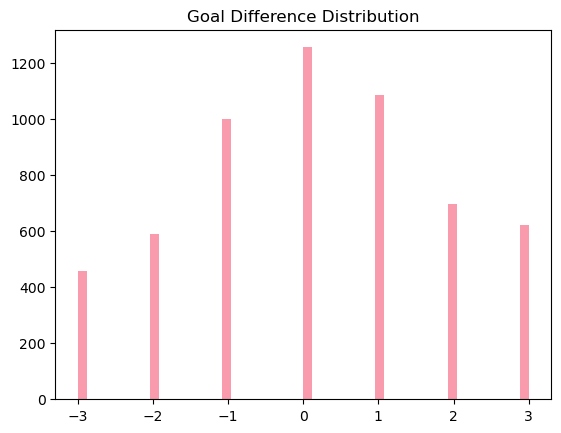

In [92]:
# Analyze goal_diff distribution       
print(df['goal_diff'].describe())      
print(f"Range: {df['goal_diff'].min()} to {df['goal_diff'].max()}")
plt.hist(df['goal_diff'], bins=50, alpha=0.7)
plt.title('Goal Difference Distribution')

In [76]:
# Import XGBoost and optimization libraries
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import joblib
from datetime import datetime

print("✓ XGBoost and optimization libraries imported successfully")

✓ XGBoost and optimization libraries imported successfully


In [77]:
# Data preparation for XGBRFRegressor
print("Preparing data for regression...")

# Analyze target variable
print("\n📊 TARGET VARIABLE ANALYSIS:")
print(f"Goal difference statistics:")
print(f" Train Mean: {y_train.mean():.3f}")
print(f"  Train Std: {y_train.std():.3f}")
print(f"  Train Min: {y_train.min()}")
print(f"  Train Max: {y_train.max()}")
print(f"  Train Range: {y_train.min()} to {y_train.max()}")

print(f"  Test Mean: {y_test.mean():.3f}")
print(f"  Test Std: {y_test.std():.3f}")
print(f"  Test Min: {y_test.min()}")
print(f"  Test Max: {y_test.max()}")
print(f"  Test Range: {y_test.min()} to {y_test.max()}")

# Handle missing values
print(f"\nMissing values before handling: {X_train[features].isnull().sum().sum()}")
print(f"Missing values before handling: {X_test[features].isnull().sum().sum()}")

# Fill missing values with median
X_train_clean = X_train[features].fillna(X_train[features].median())
X_test_clean = X_test[features].fillna(X_train[features].median())  # Use training median for test set

print(f"Missing values after handling: {X_train_clean.isnull().sum().sum()}")
print(f"Training set shape: {X_train_clean.shape}")
print(f"Test set shape: {X_test_clean.shape}")

# Create feature importance DataFrame for later use
feature_names = list(X_train_clean.columns)
print(f"Number of features: {len(feature_names)}")
print("✓ Data preparation completed")

Preparing data for regression...

📊 TARGET VARIABLE ANALYSIS:
Goal difference statistics:
 Train Mean: 0.161
  Train Std: 1.998
  Train Min: -9.0
  Train Max: 9.0
  Train Range: -9.0 to 9.0
  Test Mean: 0.000
  Test Std: 1.867
  Test Min: -7.0
  Test Max: 7.0
  Test Range: -7.0 to 7.0

Missing values before handling: 63954
Missing values before handling: 163
Missing values after handling: 0
Training set shape: (4758, 197)
Test set shape: (760, 197)
Number of features: 197
✓ Data preparation completed


In [64]:
# Hyperparameter tuning function with cross-validation
def objective(trial):
    """Objective function for Optuna optimization - minimizes MAE"""
    
    # Define hyperparameter search space for XGBRFRegressor
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'max_leaves': trial.suggest_int('max_leaves', 0, 256),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }
    
    # Time-based cross-validation (more realistic for time series data)
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_clean)):
        X_fold_train, X_fold_val = X_train_clean.iloc[train_idx], X_train_clean.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Create and train model
        model = XGBRFRegressor(**params)
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            verbose=False
        )
        
        # Predict and calculate MAE
        y_pred = model.predict(X_fold_val)
        fold_mae = mean_absolute_error(y_fold_val, y_pred)
        cv_scores.append(fold_mae)
    
    # Return mean CV MAE (Optuna minimizes by default)
    mean_mae = np.mean(cv_scores)
    return mean_mae

print("✓ Hyperparameter tuning function created")

✓ Hyperparameter tuning function created


In [65]:
# Run hyperparameter optimization
print("Starting XGBRFRegressor hyperparameter optimization...")
print("This will minimize MAE using time-series cross-validation...")
print("This may take several minutes depending on n_trials...")

# Create study
study = optuna.create_study(
    direction='minimize',  # We want to minimize MAE
    sampler=TPESampler(seed=42)
)

# Optimize hyperparameters
start_time = datetime.now()
study.optimize(objective, n_trials=100, show_progress_bar=True)
end_time = datetime.now()

print(f"\n✓ Optimization completed in {end_time - start_time}")
print(f"Best MAE: {study.best_value:.4f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

# Save the study for later analysis
study_path = models_dir / 'xgbrf_optimization_study.joblib'
joblib.dump(study, study_path)
print(f"\n✓ Study saved to: {study_path}")

[I 2025-08-10 09:40:27,964] A new study created in memory with name: no-name-6a92c0a2-ea87-41a3-a27a-f467976cb907


Starting XGBRFRegressor hyperparameter optimization...
This will minimize MAE using time-series cross-validation...
This may take several minutes depending on n_trials...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 09:40:52,039] Trial 0 finished with value: 1.4960198899322412 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bynode': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'min_child_weight': 8, 'gamma': 0.041168988591604894, 'max_leaves': 249}. Best is trial 0 with value: 1.4960198899322412.
[I 2025-08-10 09:41:01,002] Trial 1 finished with value: 1.525440707836586 and parameters: {'n_estimators': 258, 'max_depth': 4, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bynode': 0.7216968971838151, 'colsample_bylevel': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 4.17890272377219e-06, 'reg_lambda': 0.0032112643094417484, 'min_child_weight': 2, 'gamma': 0.5842892970704363, 'max_leaves': 94}. Best is trial 0 with val

In [80]:
# Train final model with best parameters
print("Training final XGBRFRegressor model with optimized parameters...")

# Get best parameters and add fixed parameters
best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
})

# Train final model on full training set
final_model = XGBRFRegressor(**best_params)
final_model.fit(
    X_train_clean, y_train,
    eval_set=[(X_test_clean, y_test)],  # Use test set for monitoring (not early stopping)
    verbose=False
)

# Save the final model
model_path = models_dir / 'xgbrf_final_model.joblib'
joblib.dump(final_model, model_path)
print(f"✓ Final model saved to: {model_path}")

# Save feature names for later use
joblib.dump(feature_names, models_dir / 'xgbrf_feature_names.joblib')
print("✓ Feature names saved")

print(f"✓ Model training completed with {final_model.n_estimators} trees")

Training final XGBRFRegressor model with optimized parameters...
✓ Final model saved to: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league\xgbrf_final_model.joblib
✓ Feature names saved
✓ Model training completed with 275 trees


In [81]:
# Evaluate model on test set with comprehensive regression metrics
print("Evaluating XGBRFRegressor on test set...")
print("=" * 60)

# Make predictions on test set
y_test_pred = final_model.predict(X_test_clean)

# Calculate regression metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"🎯 REGRESSION METRICS:")
print(f"  MAE (Mean Absolute Error): {test_mae:.4f} goals")
print(f"  MSE (Mean Squared Error):  {test_mse:.4f}")
print(f"  RMSE (Root Mean Squared Error): {test_rmse:.4f} goals")
print(f"  R² Score: {test_r2:.4f} ({test_r2*100:.1f}% variance explained)")
print(f"  Cross-validation MAE: {study.best_value:.4f}")

# Prediction accuracy within tolerance
tolerance_1 = np.mean(np.abs(y_test - y_test_pred) <= 1.0)
tolerance_0_5 = np.mean(np.abs(y_test - y_test_pred) <= 0.5)

print(f"\n🎯 PREDICTION ACCURACY:")
print(f"  Within ±0.5 goals: {tolerance_0_5*100:.1f}%")
print(f"  Within ±1.0 goals: {tolerance_1*100:.1f}%")

# Residual analysis
residuals = y_test - y_test_pred
print(f"\n📊 RESIDUAL ANALYSIS:")
print(f"  Mean residual: {residuals.mean():.4f}")
print(f"  Std residual: {residuals.std():.4f}")
print(f"  Max over-prediction: {residuals.min():.2f} (predicted too high)")
print(f"  Max under-prediction: {residuals.max():.2f} (predicted too low)")

# Feature importance
print(f"\n🔍 TOP 20 MOST IMPORTANT FEATURES:")
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance.head(20).iterrows()):
    print(f"  {i+1:2d}. {row['feature']}: {row['importance']:.4f}")

# Test set distribution comparison
print(f"\n📋 TEST SET INFO:")
print(f"  Total matches: {len(y_test)}")
print(f"  Actual goal diff - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")
print(f"  Predicted goal diff - Mean: {y_test_pred.mean():.3f}, Std: {y_test_pred.std():.3f}")
print(f"  Range actual: {y_test.min()} to {y_test.max()}")
print(f"  Range predicted: {y_test_pred.min():.2f} to {y_test_pred.max():.2f}")

print(f"\n✅ REGRESSION EVALUATION COMPLETED!")
print(f"🎯 PRIMARY METRIC - Test MAE: {test_mae:.4f} goals")

Evaluating XGBRFRegressor on test set...
🎯 REGRESSION METRICS:
  MAE (Mean Absolute Error): 1.3924 goals
  MSE (Mean Squared Error):  3.2439
  RMSE (Root Mean Squared Error): 1.8011 goals
  R² Score: 0.0683 (6.8% variance explained)
  Cross-validation MAE: 1.4598

🎯 PREDICTION ACCURACY:
  Within ±0.5 goals: 24.3%
  Within ±1.0 goals: 46.3%

📊 RESIDUAL ANALYSIS:
  Mean residual: -0.1072
  Std residual: 1.7991
  Max over-prediction: -7.02 (predicted too high)
  Max under-prediction: 6.78 (predicted too low)

🔍 TOP 20 MOST IMPORTANT FEATURES:
   1. avg_wage_dollars_diff: 0.0617
   2. max_wage_dollars_diff: 0.0385
   3. total_wage_bill_dollars_diff: 0.0247
   4. possession_dominance: 0.0188
   5. Possession_against_form_sum: 0.0181
   6. Touches_favor_form_avg: 0.0163
   7. Possession_against_opponent_form_sum: 0.0151
   8. Possession_favor_opponent_form_avg: 0.0113
   9. Possession_favor_form_avg: 0.0112
  10. Possession_favor_form_sum: 0.0109
  11. Premier League: 0.0106
  12. Possession

In [93]:
# Convert goal difference predictions to match outcomes
print("Converting goal difference predictions to match outcomes...")
print("=" * 60)

def goal_diff_to_result(goal_diff_pred, threshold=0.5):
    """Convert goal difference predictions to W/D/L outcomes"""
    return np.where(goal_diff_pred > threshold, 'W',
                   np.where(goal_diff_pred < -threshold, 'L', 'D'))

# Get actual results for test set
y_test_actual_results = df_test['result'].values

# Convert predictions to match outcomes with different thresholds
thresholds = np.linspace(0.05, 1.0, 15)
print("🔄 MATCH OUTCOME PREDICTION ACCURACY:")

best_accuracy = 0
best_threshold = 0.5

for threshold in thresholds:
    y_test_pred_results = goal_diff_to_result(y_test_pred, threshold)
    
    # Calculate accuracy
    outcome_accuracy = accuracy_score(y_test_actual_results, y_test_pred_results)
    
    print(f"  Threshold ±{threshold}: {outcome_accuracy:.4f} ({outcome_accuracy*100:.1f}%)")
    
    if outcome_accuracy > best_accuracy:
        best_accuracy = outcome_accuracy
        best_threshold = threshold

print(f"\n🏆 BEST OUTCOME ACCURACY: {best_accuracy:.4f} ({best_accuracy*100:.1f}%) at threshold ±{best_threshold}")

# Detailed analysis with best threshold
y_test_pred_results_best = goal_diff_to_result(y_test_pred, best_threshold)

print(f"\n📊 DETAILED CLASSIFICATION REPORT (Threshold ±{best_threshold}):")
print(classification_report(y_test_actual_results, y_test_pred_results_best))

print(f"\n📈 CONFUSION MATRIX (Threshold ±{best_threshold}):")
cm = confusion_matrix(y_test_actual_results, y_test_pred_results_best, labels=['W', 'D', 'L'])
print("     Predicted")
print("     W    D    L")
for i, actual in enumerate(['W', 'D', 'L']):
    print(f"{actual}  {cm[i][0]:3d} {cm[i][1]:3d} {cm[i][2]:3d}")

# Per-class accuracies
print(f"\n🎯 PER-CLASS ACCURACY (Threshold ±{best_threshold}):")
for i, class_name in enumerate(['Win', 'Draw', 'Loss']):
    if cm[i].sum() > 0:  # Avoid division by zero
        class_accuracy = cm[i, i] / cm[i].sum()
        print(f"  {class_name}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

# Comparison summary
print(f"\n📊 MODEL COMPARISON SUMMARY:")
print(f"  Regression MAE: {test_mae:.4f} goals")
print(f"  Classification Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.1f}%)")
print(f"  Previous Classification Model: ~49% accuracy")
if best_accuracy > 0.49:
    improvement = (best_accuracy - 0.49) * 100
    print(f"  🎉 Improvement: +{improvement:.1f} percentage points!")
else:
    decline = (0.49 - best_accuracy) * 100
    print(f"  📉 Decline: -{decline:.1f} percentage points")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'actual_goal_diff': y_test.values,
    'predicted_goal_diff': y_test_pred,
    'actual_result': y_test_actual_results,
    'predicted_result': y_test_pred_results_best,
    'residual': y_test.values - y_test_pred
})

predictions_path = models_dir / 'xgbrf_test_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"\n💾 Test predictions saved to: {predictions_path}")

print(f"\n✅ GOAL DIFFERENCE TO OUTCOME CONVERSION COMPLETED!")

Converting goal difference predictions to match outcomes...
🔄 MATCH OUTCOME PREDICTION ACCURACY:
  Threshold ±0.05: 0.4737 (47.4%)
  Threshold ±0.11785714285714285: 0.4382 (43.8%)
  Threshold ±0.18571428571428572: 0.4132 (41.3%)
  Threshold ±0.25357142857142856: 0.3658 (36.6%)
  Threshold ±0.3214285714285714: 0.3197 (32.0%)
  Threshold ±0.38928571428571423: 0.3026 (30.3%)
  Threshold ±0.45714285714285713: 0.2776 (27.8%)
  Threshold ±0.525: 0.2645 (26.4%)
  Threshold ±0.5928571428571429: 0.2526 (25.3%)
  Threshold ±0.6607142857142857: 0.2500 (25.0%)
  Threshold ±0.7285714285714285: 0.2447 (24.5%)
  Threshold ±0.7964285714285714: 0.2447 (24.5%)
  Threshold ±0.8642857142857143: 0.2447 (24.5%)
  Threshold ±0.9321428571428572: 0.2447 (24.5%)
  Threshold ±1.0: 0.2447 (24.5%)

🏆 BEST OUTCOME ACCURACY: 0.4737 (47.4%) at threshold ±0.05

📊 DETAILED CLASSIFICATION REPORT (Threshold ±0.05):
              precision    recall  f1-score   support

           D       0.28      0.14      0.19       18

In [88]:
predictions_df

,actual_goal_diff,predicted_goal_diff,actual_result,predicted_result,residual
0,2.0,0.447046,W,W,1.552954
1,2.0,0.222713,W,W,1.777287
2,0.0,0.413955,D,W,-0.413955
3,1.0,0.089215,W,W,0.910785
4,0.0,-0.191450,D,L,0.191450
...,...,...,...,...,...
755,1.0,0.228665,W,W,0.771335
756,-1.0,-0.074739,L,L,-0.925261
757,-2.0,0.298642,L,W,-2.298642
758,1.0,0.277336,W,W,0.722664


In [71]:
y_test

258     2.0
259     2.0
260     0.0
261     1.0
263     0.0
       ... 
5706    1.0
5707   -1.0
5708   -2.0
5709    1.0
5710   -2.0
Name: goal_diff, Length: 760, dtype: float64